In [1]:
import scipy.io as spio
import matplotlib.pyplot as plt
import sys
import warnings
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from math import log
import numpy as np
import numpy.testing as npt
from numpy import isneginf
np.seterr(divide='ignore')
import scipy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [24]:
import pandas as pd
import seaborn as sns

In [2]:
d4train1000_data = spio.loadmat('d41_train1000.mat')['data']
d4train1000_labels = spio.loadmat('d41_train1000.mat')['labels']

d4test10k_data = spio.loadmat('d41_train10k.mat')['data']
d4test10k_labels = spio.loadmat('d41_train10k.mat')['labels']


In [20]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)

In [3]:
def tenFoldCrossVal(data, labels):
    
    
    #Attach labels to data
    X = data
    y = labels


    scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    y = y.reshape(-1)
    #Split the data in 10 batches
    sizeBatches = 10
    kf = KFold(n_splits=sizeBatches, shuffle=True)
    
    print(X.shape, y.shape)
    C_range = np.logspace(-3.0, 3.0, num=10)
    gamma_range = np.logspace(-3.0, 3.0, num=10)
    param_grid = dict(gamma=gamma_range, C=C_range)
    grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid=param_grid, \
                        cv=kf, return_train_score=True)
    grid.fit(X, y)

    print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))
    #print(grid.cv_results_)
    
    return grid.best_estimator_

In [26]:
def fitAndTest(p_hat, data, labels):
    
    #Attach labels to data
    X = data
    y = labels

    scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    y = y.reshape(-1)
    #sv = SVC(kernel='rbf', C=p_hat['C'], gamma=p_hat['gamma'])
    print(p_hat.get_params())
    #p_hat.fit(data, y)
    y_hat = p_hat.predict(data)
    print(y_hat)
    a = accuracy_score(y, y_hat, normalize=False)
    plt.figure()
    plt.xlabel("X")
    for i in range(len(y_hat)):
        if y_hat[i] == 1:
            plt.plot(X[i][0], X[i][1], 'r.', zorder=2)
        if y_hat[i] == 2:
            plt.plot(X[i][0], X[i][1], 'b.', zorder=1)
    plt.savefig("HW4_Q2")
    labels = [1, 2]
    cm = confusion_matrix(y, y_hat, labels)
    #cm_analysis(y, y_hat, "SVM_ConfusionMatrix.png", labels)
    print(a)
   

In [5]:
p_hat = tenFoldCrossVal(d4train1000_data.T, d4train1000_labels)

(1000, 2) (1000,)
The best parameters are {'C': 10.0, 'gamma': 0.004641588833612777} with a score of 0.97


{'C': 10.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.004641588833612777, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
[1 2 2 ... 2 2 2]
9720


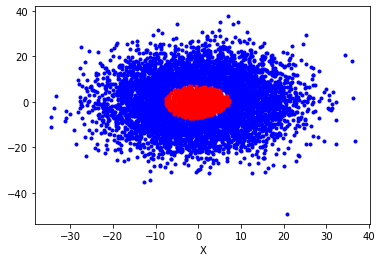

In [27]:
#fitAndTest(p_hat, d4train1000_data.T, d4train1000_labels)
fitAndTest(p_hat, d4test10k_data.T, d4test10k_labels)